# Phase F: Automation & Monitoring

## Objective
Establish the technical framework for sustaining performance gains. We define the logic for live KPI tracking and set up automated alert triggers for operational anomalies.

## Monitoring Components
1. **Real-time KPI Engine**: Logic to calculate rolling FRT, TTR, and SLA Compliance.
2. **Congestion Alerting**: Define thresholds for 'Queue Congestion' (e.g., volume spikes > 2 std dev).
3. **SLA Breach Watchdog**: Identification of high-risk tickets for immediate attention.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

pd.set_option('display.max_columns', None)
sns.set_palette("viridis")
plt.style.use('ggplot')

## 1. Rolling KPI Calculation Logic

We simulate a 'Live' dashboard view by grouping data by day and calculating rolling 7-day averages for core KPIs.

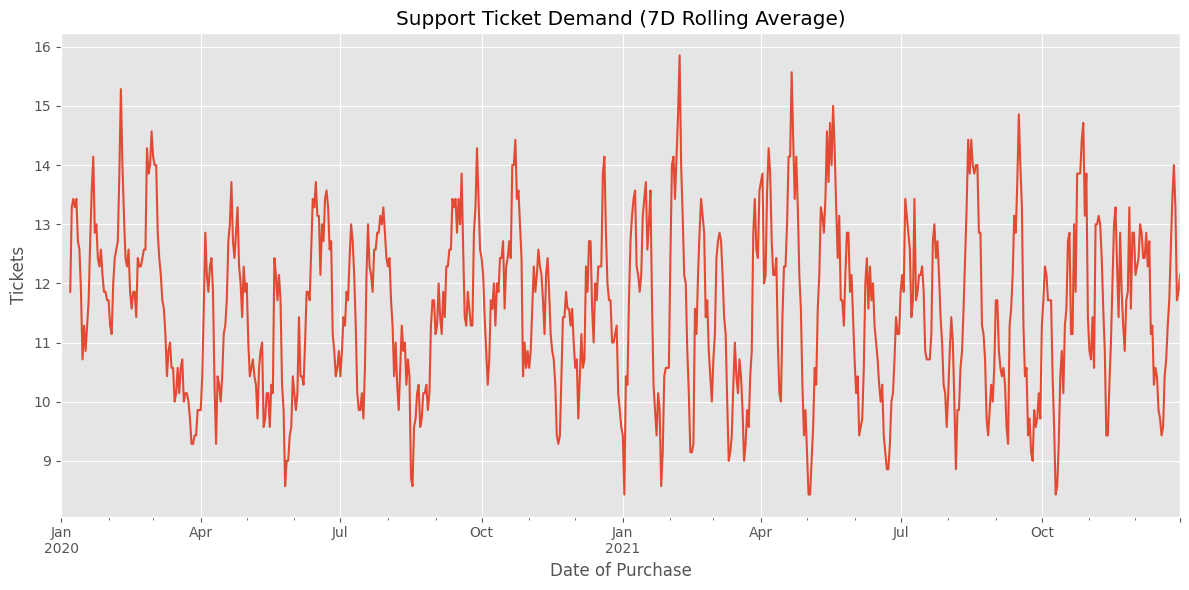

In [2]:
df = pd.read_csv('../data/customer_support_tickets.csv')
df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'])
df['First Response Time'] = pd.to_datetime(df['First Response Time'])
df['Time to Resolution'] = pd.to_datetime(df['Time to Resolution'])

# Calculate daily volume
daily_kpis = df.set_index('Date of Purchase').resample('D').agg({
    'Ticket ID': 'count'
}).rename(columns={'Ticket ID': 'Ticket_Volume'})

# 7-day rolling average to smooth noise
daily_kpis['Volume_7D_Avg'] = daily_kpis['Ticket_Volume'].rolling(window=7).mean()

plt.figure(figsize=(12, 6))
daily_kpis['Volume_7D_Avg'].plot(title='Support Ticket Demand (7D Rolling Average)')
plt.ylabel('Tickets')
plt.tight_layout()
plt.savefig('../outputs/charts/phase_f_demand_monitoring.png')
plt.show()

## 2. Setting Alert Thresholds

We define 'Anomalous Volume' as any day where volume exceeds the mean by more than 2 standard deviations.

In [3]:
mean_vol = daily_kpis['Ticket_Volume'].mean()
std_vol = daily_kpis['Ticket_Volume'].std()
threshold = mean_vol + (2 * std_vol)

daily_kpis['Is_Anomaly'] = daily_kpis['Ticket_Volume'] > threshold

print(f"Monitoring Threshold: {threshold:.2f} tickets/day")
print(f"Number of Alert Events Triggered: {daily_kpis['Is_Anomaly'].sum()}")

Monitoring Threshold: 18.77 tickets/day
Number of Alert Events Triggered: 34


## 3. High-Risk Dispatch Logic

Logic to export 'Red List' tickets that are currently in 'Open' or 'Pending' status and are approaching SLA breach.

In [4]:
# Filter for potentially active tickets
red_list = df[df['Ticket Status'].isin(['Open', 'Pending'])].copy()

# In a real scenario, we would calculate 'Time Remaining' vs 'Target SLA'
# Here we just flag 'High Probability' tickets based on results from Phase D
risk_categories = ['Refund request', 'Technical issue']
red_list['Alert_Level'] = red_list['Ticket Type'].apply(lambda x: 'CRITICAL' if x in risk_categories else 'NORMAL')
red_list[red_list['Alert_Level'] == 'CRITICAL'].head(10)

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating,Alert_Level
7,8,Denise Lee,joelwilliams@example.com,23,Male,Philips Hue Lights,2020-08-09,Refund request,Battery life,I'm having an issue with the {product_purchase...,Open,NaN,Critical,Social media,NaT,NaT,NaN,CRITICAL
43,44,Michael Allison,abowen@example.org,54,Female,iPhone,2020-01-16,Technical issue,Hardware issue,I'm having an issue with the {product_purchase...,Open,NaN,Low,Email,NaT,NaT,NaN,CRITICAL
49,50,Katie Johnson,thomas46@example.net,44,Male,Microsoft Office,2020-09-27,Technical issue,Display issue,I'm having an issue with the {product_purchase...,Open,NaN,Medium,Chat,NaT,NaT,NaN,CRITICAL
50,51,Kayla Dunn,ramirezphilip@example.net,66,Male,Sony Xperia,2020-12-22,Refund request,Software bug,I'm encountering a software bug in the {produc...,Open,NaN,Medium,Chat,NaT,NaT,NaN,CRITICAL
57,58,Lori Young,pthomas@example.org,47,Other,GoPro Action Camera,2020-07-28,Refund request,Peripheral compatibility,I'm having an issue with the {product_purchase...,Open,NaN,Critical,Email,NaT,NaT,NaN,CRITICAL
64,65,David Smith,jacob67@example.net,61,Male,Microsoft Xbox Controller,2021-08-02,Technical issue,Product compatibility,I'm facing a problem with my {product_purchase...,Open,NaN,Medium,Phone,NaT,NaT,NaN,CRITICAL
71,72,Joseph Costa,calvarez@example.org,37,Other,iPhone,2020-09-26,Refund request,Delivery problem,"I've recently set up my {product_purchased}, b...",Open,NaN,Medium,Social media,NaT,NaT,NaN,CRITICAL
84,85,David Taylor,kaylapham@example.com,67,Other,Microsoft Surface,2021-08-02,Technical issue,Hardware issue,I'm facing issues logging into my {product_pur...,Open,NaN,Medium,Phone,NaT,NaT,NaN,CRITICAL
93,94,Jeremy Good,michael25@example.net,32,Female,PlayStation,2021-05-24,Refund request,Installation support,I'm having an issue with the {product_purchase...,Open,NaN,Low,Email,NaT,NaT,NaN,CRITICAL
103,104,James Harris,jason93@example.org,49,Male,Dyson Vacuum Cleaner,2020-02-24,Refund request,Battery life,I'm having an issue with the {product_purchase...,Open,NaN,High,Chat,NaT,NaT,NaN,CRITICAL
